In [116]:
import cv2
import imutils
import numpy as np
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import matplotlib.pyplot as plt


## Loading the neural network

In [117]:
loaded_network = load_model('./custom-ocr-network')

loaded_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 128)         0

## Loading the test image

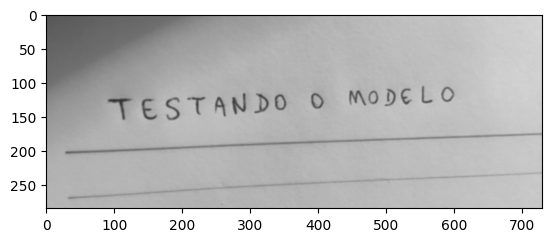

In [118]:
img = cv2.imread('../images/test.png')
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img, cmap='gray')
plt.show()

## Pre-processing the image

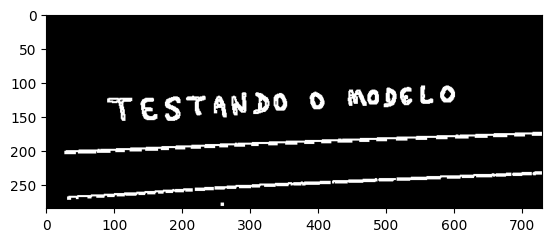

In [119]:

# Noise Reduction
blurred_image = cv2.GaussianBlur(img, (1, 1), 0)

# Convert to grayscale
gray_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)

blur = cv2.GaussianBlur(gray_image, (3,3), 0)

adaptive = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)

# make the background black
invertion = 255 - adaptive

# to remove the noise 
dilation = cv2.dilate(invertion, np.ones((1,1)))    

edges = cv2.Canny(dilation, 40, 150)

dilation = cv2.dilate(edges, np.ones((3,3)))
    
plt.imshow(dilation, cmap='gray')
plt.show()

## Countour detection

In [120]:
def find_contours(img):
  conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sort_contours(conts, method = 'left-to-right')[0]
  return conts

conts = find_contours(dilation.copy())

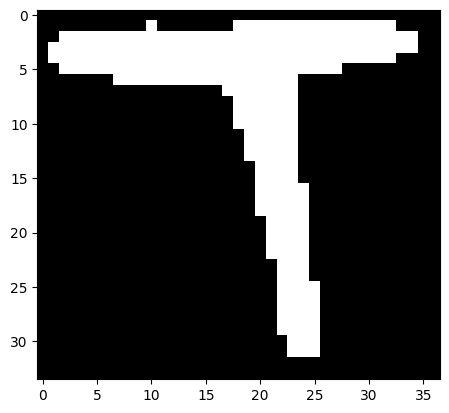

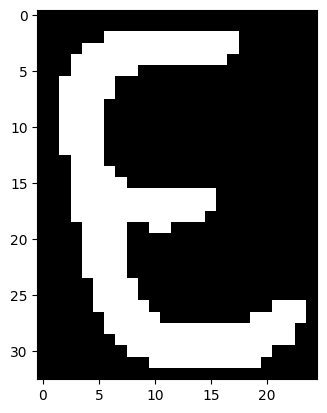

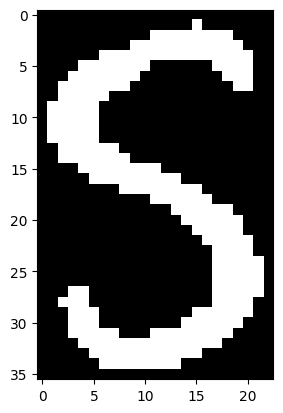

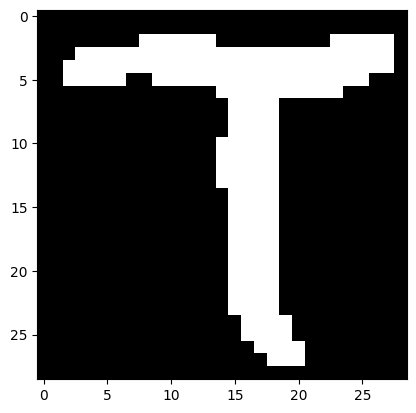

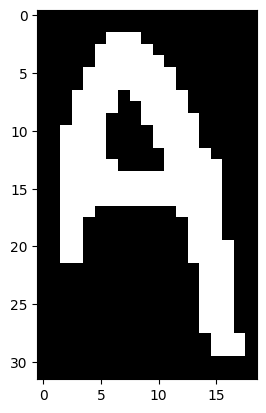

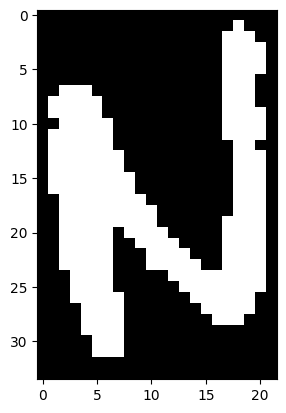

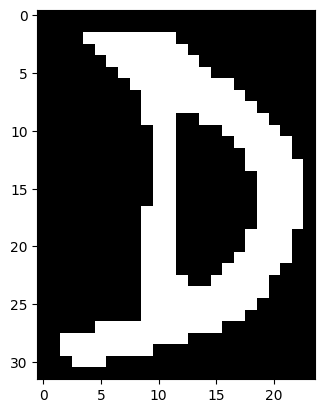

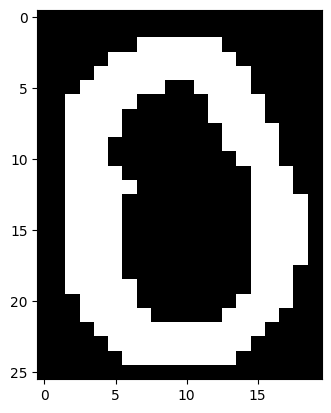

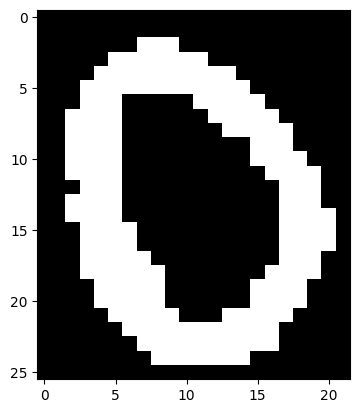

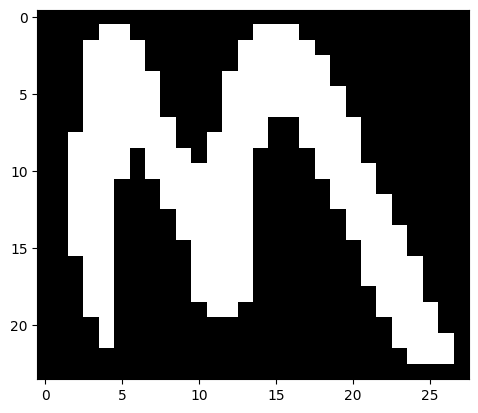

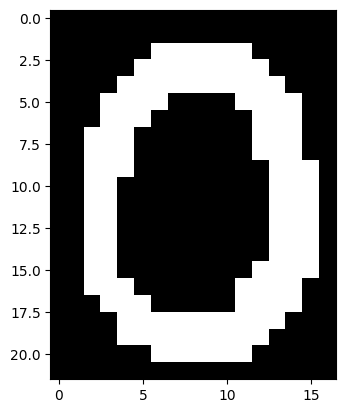

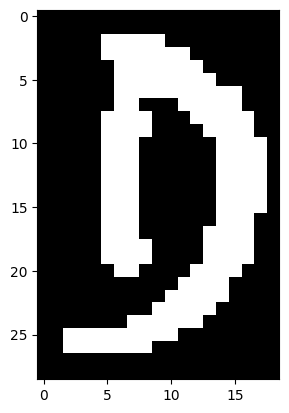

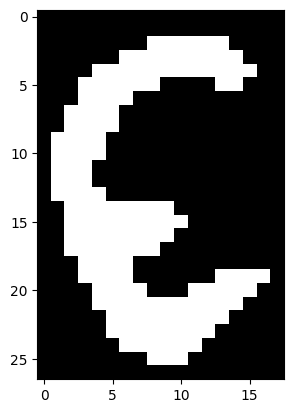

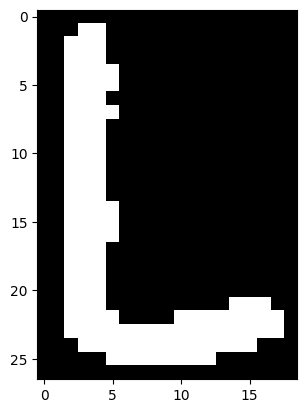

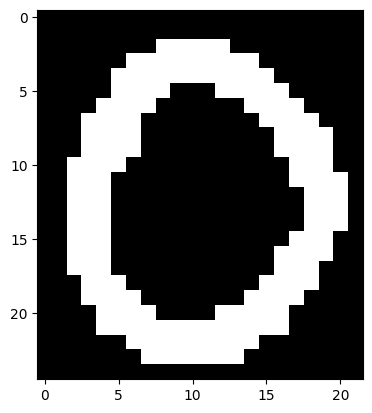

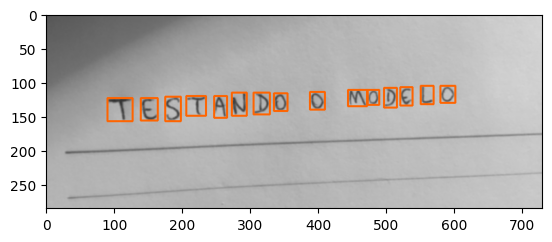

In [121]:
min_w, max_w = 4, 160
min_h, max_h = 14, 140
img_copy = img.copy()
for c in conts:
  (x, y, w, h) = cv2.boundingRect(c)
  if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
    roi = gray_image[y:y+h, x:x+w]
    thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    plt.imshow(thresh, cmap='gray')
    plt.show()
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255, 100, 0), 2)

plt.imshow(img_copy)
plt.show()

## Processing the detected characters

In [122]:
def extract_roi(img):
  roi = img[y:y + h, x:x + w]
  return roi

In [123]:
def thresholding(img):
  thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  return thresh

In [124]:
def resize_img(img, w, h):
  if w > h:
    resized = imutils.resize(img, width = 28)
  else:
    resized = imutils.resize(img, height = 28)

  (h, w) = resized.shape
  dX = int(max(0, 28 - w) / 2.0)
  dY = int(max(0, 28 - h) / 2.0)

  filled = cv2.copyMakeBorder(resized, top=dY, bottom=dY, right=dX, left=dX, borderType=cv2.BORDER_CONSTANT, value = (0,0,0))
  filled = cv2.resize(filled, (28,28))
  return filled

27 173 703 33


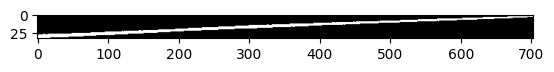

33 703


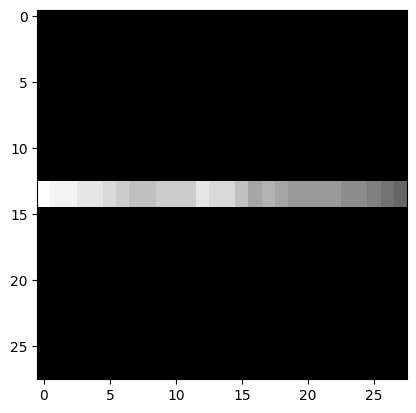

(28, 28)


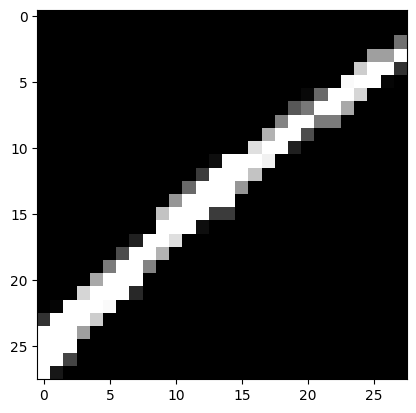

In [127]:
(x, y, w, h) = cv2.boundingRect(conts[0])
print(x, y, w, h)
test_img = thresholding(gray_image[y:y+h, x:x+w])
plt.imshow(test_img, cmap='gray')
plt.show()
(h, w) = test_img.shape
print(h, w)
test_img2 = resize_img(test_img, w, h)
plt.imshow(test_img2, cmap='gray')
plt.show()
print(test_img2.shape)

plt.imshow(cv2.resize(test_img, (28,28)), cmap='gray')
plt.show()

## Normalization

In [128]:
def normalization(img):
  img = img.astype('float32') / 255.0
  img = np.expand_dims(img, axis = -1)
  return img

## Processing the detections

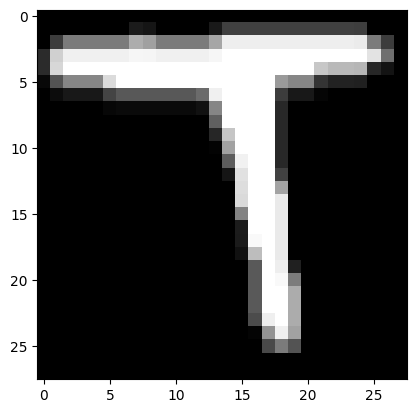

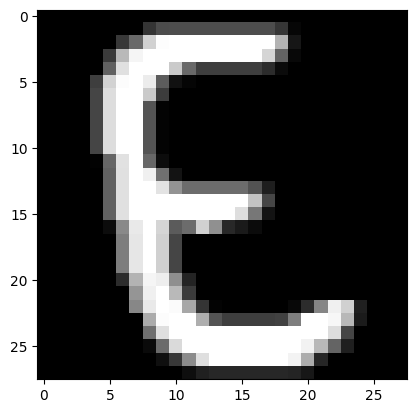

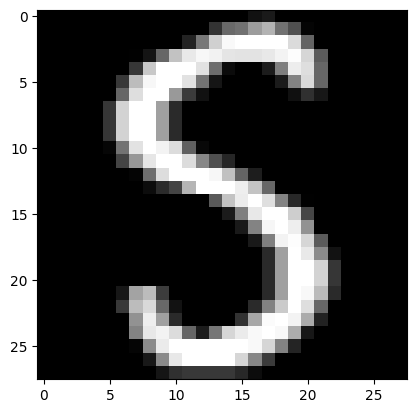

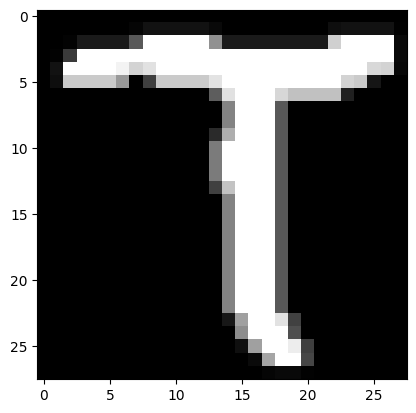

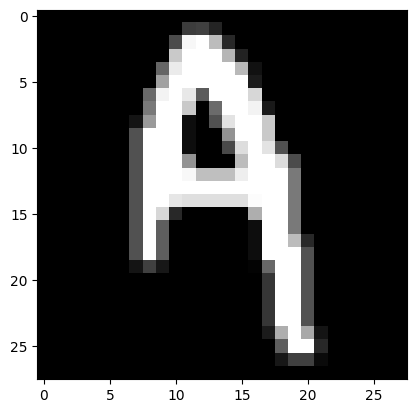

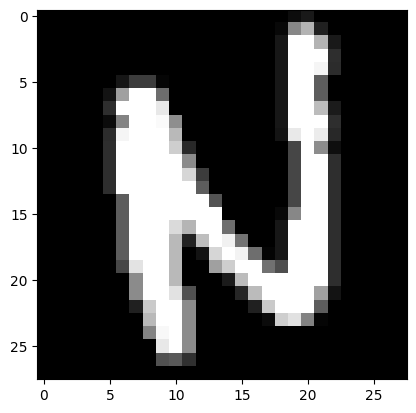

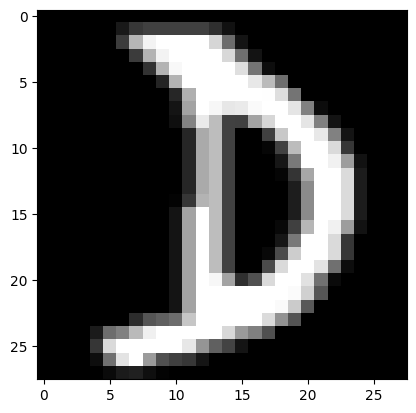

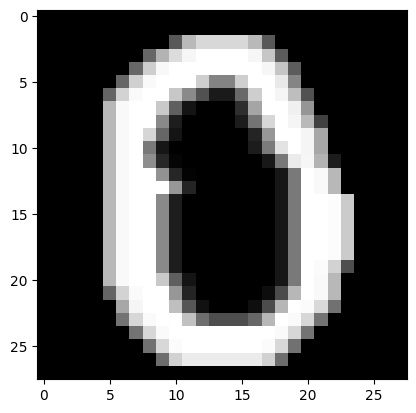

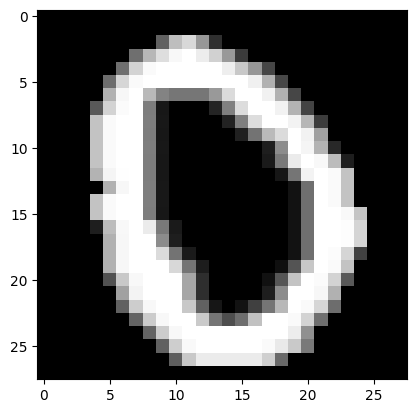

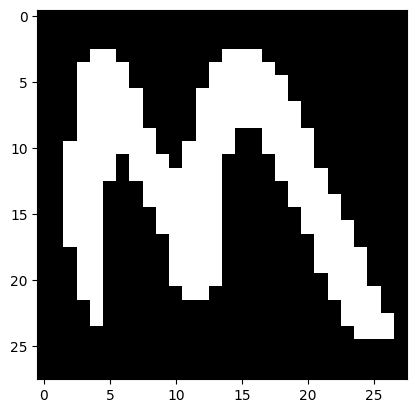

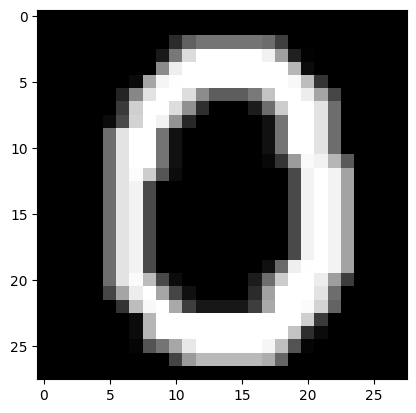

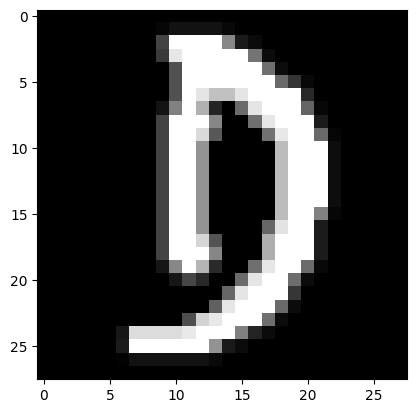

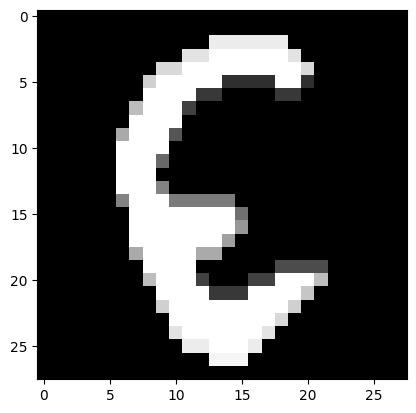

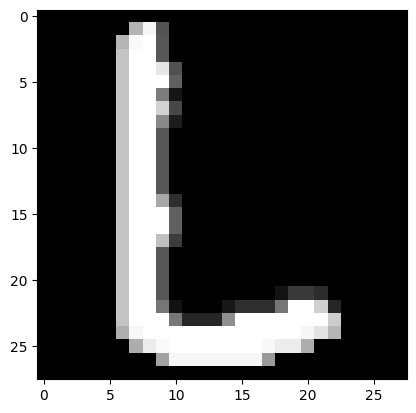

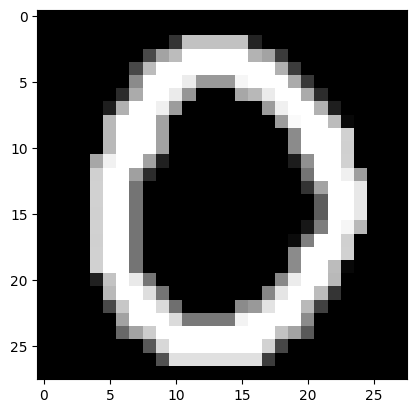

In [130]:
characters = []

def process_box(gray, x, y, w, h):
  roi = extract_roi(gray)
  thresh = thresholding(roi)
  (h, w) = thresh.shape
  resized = resize_img(thresh, w, h)
  plt.imshow(resized, cmap='gray')
  plt.show()
  normalized = normalization(resized)
  characters.append((normalized, (x, y, w, h)))


for c in conts:
  (x, y, w, h) = cv2.boundingRect(c)
  if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
    process_box(gray_image, x, y, w, h)

In [136]:
boxes = [box[1] for box in characters]
boxes

[(90, 123, 37, 34),
 (139, 123, 25, 33),
 (175, 121, 23, 36),
 (206, 120, 29, 29),
 (247, 120, 19, 32),
 (273, 115, 22, 34),
 (305, 115, 24, 32),
 (335, 116, 20, 26),
 (388, 114, 22, 26),
 (444, 111, 28, 24),
 (473, 111, 17, 22),
 (497, 108, 19, 29),
 (521, 107, 18, 27),
 (551, 105, 19, 27),
 (580, 105, 22, 25)]

In [132]:
pixels = np.array([pixel[0] for pixel in characters], dtype = 'float32')

[[[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.23529412]
   [0.48235294]
   ...
   [0.48235294]
   [0.23529412]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0. 

## Recognition of characters

In [133]:
digits = '0123456789'
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
characters_list = digits + letters
characters_list = [l for l in characters_list]

In [134]:
predictions = loaded_network.predict(pixels)

1/1 [==============================] - 0s 308ms/step


In [135]:
predictions.shape

(15, 36)

T  ->  99.9916136264801
E  ->  99.9998152256012
S  ->  51.62197947502136
T  ->  99.99992251396179
A  ->  96.8646228313446
N  ->  99.8919665813446
D  ->  99.98719692230225
D  ->  51.16451382637024
O  ->  92.95309782028198
M  ->  99.85617995262146
0  ->  86.81581020355225
D  ->  99.98831748962402
E  ->  89.40020203590393
L  ->  99.99998807907104
0  ->  55.28360605239868


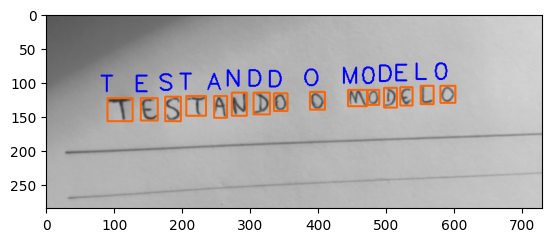

In [137]:
img_copy = img.copy()
for (prediction, (x, y, w, h)) in zip(predictions, boxes):
  i = np.argmax(prediction)
  #print(i)
  probability = prediction[i]
  #print(probability)
  character = characters_list[i]
  #print(character)

  cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255,100,0), 2)
  cv2.putText(img_copy, character, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0,0,255), 2)
  print(character, ' -> ', probability * 100)

  plt.imshow(img_copy, cmap='gray')